In [1]:
import numpy as np
import pandas as pd
import os
from scipy import optimize

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    adjust_yaxis(ax2,(y1-y2)/2,v2)
    adjust_yaxis(ax1,(y2-y1)/2,v1)

def adjust_yaxis(ax,ydif,v):
    """shift axis ax by ydiff, maintaining point v at the same location"""
    inv = ax.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, ydif))
    miny, maxy = ax.get_ylim()
    miny, maxy = miny - v, maxy - v
    if -miny>maxy or (-miny==maxy and dy > 0):
        nminy = miny
        nmaxy = miny*(maxy+dy)/(miny+dy)
    else:
        nmaxy = maxy
        nminy = maxy*(miny+dy)/(maxy+dy)
    ax.set_ylim(nminy+v, nmaxy+v)
    
def fit(x, x0, x1, b, k1, k2, k3):
    condlist = [x < x0, (x >= x0) & (x < x1), x >= x1]
    funclist = [lambda x: k1*x + b, lambda x: k1*x0 + b + k2*(x-x0), lambda x: k1*x0 + b + k2*(x1-x0) + k3*(x - x1)]
    return np.piecewise(x, condlist, funclist)

def invfit(x, x0, x1, b, k1, k2, k3):
    condlist = [x < k1*x0+b, (x >= k1*x0+b) & (x < k1*x0 + b + k2*(x1-x0)), x >= k1*x0 + b + k2*(x1-x0)]
    funclist = [lambda x: (x - b) / k1, lambda x: (x - k1*x0 - b) / k2 + x0, lambda x: (x - k1*x0 - b - k2*(x1-x0)) / k3 + x1]
    return np.piecewise(x, condlist, funclist)

In [3]:
file1=os.path.expanduser('~/Documents/log/2019-01-16T16-52-52/logstream_ActAdapEsc.bin')
#file2=os.path.expanduser('~/Documents/log/2019-01-08T15-00-00/logstream_ActAdapEsc.bin')

In [4]:
dt = np.dtype([('idx', '>u1'),
               ('cmdSec', '>u4'), ('cmdUsec', '>u4'), ('cmd', '>u4'), ('cmdVel', '>f8'),
               ('fbSec', '>u4'), ('fbUsec', '>u4'), ('angVel', '>f8'),
               
               ('length', '>u2'),
               ('counts', '>u2'),
               ('voltage', '>u2'),
               ('temperature', '>u2'),
               ('current', '>u2'),
               ('id', 'u1')])

In [5]:
data1 = np.fromfile(file1, dtype=dt)
df1 = pd.DataFrame(data1.byteswap().newbyteorder())

#data2 = np.fromfile(file2, dtype=dt)
#df2 = pd.DataFrame(data2.byteswap().newbyteorder())

mot0=df1.loc[(df1['idx'] == 0) & (df1['cmd'] <= 800)]
mot1=df1.loc[(df1['idx'] == 1) & (df1['cmd'] <= 800)]
mot2=df1.loc[(df1['idx'] == 2) & (df1['cmd'] <= 800)]
mot3=df1.loc[(df1['idx'] == 3) & (df1['cmd'] <= 800)]

mot0_cmdTime = mot0.cmdSec + mot0.cmdUsec / (1000.0 * 1000.0)
mot1_cmdTime = mot1.cmdSec + mot1.cmdUsec / (1000.0 * 1000.0)
mot2_cmdTime = mot2.cmdSec + mot2.cmdUsec / (1000.0 * 1000.0)
mot3_cmdTime = mot3.cmdSec + mot3.cmdUsec / (1000.0 * 1000.0)

mot0_fbTime = mot0.fbSec + mot0.fbUsec / (1000.0 * 1000.0)
mot1_fbTime = mot1.fbSec + mot1.fbUsec / (1000.0 * 1000.0)
mot2_fbTime = mot2.fbSec + mot2.fbUsec / (1000.0 * 1000.0)
mot3_fbTime = mot3.fbSec + mot3.fbUsec / (1000.0 * 1000.0)

#df1=df1.loc[(df1['id'] == 171) & (df1['idx'] == 0)]
#df2=df2.loc[(df2['id'] == 171) & (df2['idx'] == 0)]

5.9088739785289945 616.5327694463953


/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


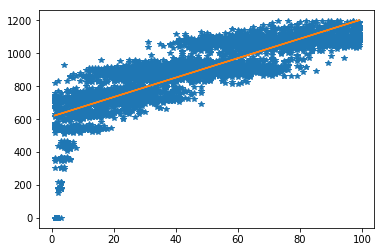

In [7]:
cmdLow = mot0.cmd[(mot0.cmd > 0) & (mot0.cmd < 200) & (mot0.angVel < 1200)].values.astype("float64")
angVelLow = mot0.angVel[(mot0.cmd > 0) & (mot0.cmd < 200) & (mot0.angVel < 1200)].values
A = np.vstack([cmdLow, np.ones(len(cmdLow))]).T
mLow, cLow = np.linalg.lstsq(A, angVelLow)[0]
print(mLow, cLow)
plt.plot(cmdLow, angVelLow, '*')
plt.plot(cmdLow, mLow*cmdLow + cLow)

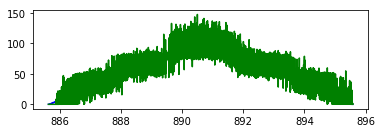

In [8]:
ax1=plt.subplot(2, 1, 1)

ax1.plot(mot0_cmdTime, mot0.cmd, 'b')
ax1.plot(mot0_fbTime, np.clip(invfit(mot0.angVel.values, 100, 300, 600, 6, 3.5, 2.14), 0, None), 'g')

#ax2=plt.subplot(2, 1, 2)
#ax2.plot(mot0_cmdTime, mot0.cmdVel - mot0.angVel)

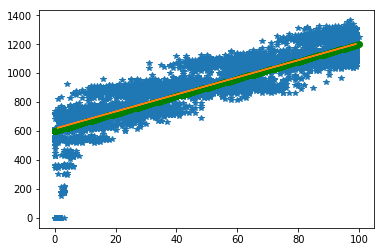

In [9]:
cmd = mot0.cmd.values.astype("float64")
angVel = mot0.angVel.values
plt.plot(cmd, angVel, '*')
plt.plot(cmd, fit(cmd, 100, 300, 600, 6, 3.5, 2.14), 'go', linestyle='None')
plt.plot(cmdLow, mLow*cmdLow + cLow)